In [13]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
data = pd.read_csv('../input/spam-classification-for-basic-nlp/Spam Email raw text for NLP.csv')
data

,CATEGORY,MESSAGE,FILE_NAME
0,1,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",00249.5f45607c1bffe89f60ba1ec9f878039a
1,1,ATTENTION: This is a MUST for ALL Computer Use...,00373.ebe8670ac56b04125c25100a36ab0510
2,1,This is a multi-part message in MIME format.\n...,00214.1367039e50dc6b7adb0f2aa8aba83216
3,1,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,00210.050ffd105bd4e006771ee63cabc59978
4,1,This is the bottom line. If you can GIVE AWAY...,00033.9babb58d9298daa2963d4f514193d7d6
...,...,...,...
5791,0,"I'm one of the 30,000 but it's not working ver...",00609.dd49926ce94a1ea328cce9b62825bc97
5792,0,Damien Morton quoted:\n\n>W3C approves HTML 4 ...,00957.e0b56b117f3ec5f85e432a9d2a47801f
5793,0,"On Mon, 2002-07-22 at 06:50, che wrote:\n\n\n\...",01127.841233b48eceb74a825417d8d918abf8
5794,0,"Once upon a time, Manfred wrote :\n\n\n\n> I w...",01178.5c977dff972cd6eef64d4173b90307f0


In [3]:
def get_sequences(texts, tokenizer, train=True, max_seq_length = None):
    sequences = tokenizer.texts_to_sequences(texts)
    
    if train == True:
        max_seq_length = np.max(list(map(lambda x:len(x), sequences)))
        
    sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen = max_seq_length, padding='post')
    
    return sequences

In [4]:
def preprocess_inputs(df):
    df = df.copy()
    
    ## Drop the filename column
    df = df.drop('FILE_NAME', axis = 1)
    
    ## Split the df
    y = df['CATEGORY']
    X = df['MESSAGE']
    
    ## Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, shuffle = True, random_state = 1)
    
    ## Create tokenizer
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = 30000)
    
    ## Fit the tokenizer
    tokenizer.fit_on_texts(X_train)
    
    ## Convert texts to sequences
    X_train = get_sequences(X_train, tokenizer, train = True)
    X_test = get_sequences(X_test, tokenizer, train = False, max_seq_length = X_train.shape[1])
    
    return X_train, X_test, y_train, y_test

In [5]:
X_train, X_test, y_train, y_test = preprocess_inputs(data)
X_train

array([[   14,   135,   188, ...,     0,     0,     0],
       [  183,  1452,  2119, ...,     0,     0,     0],
       [   56,   129,    20, ...,     0,     0,     0],
       ...,
       [  309,    12,    32, ...,     0,     0,     0],
       [   56,   179,   298, ...,     0,     0,     0],
       [   94,  4671, 11648, ...,     0,     0,     0]], dtype=int32)

In [6]:
X_train.shape

(4057, 14804)

2022-12-16 04:47:06.854708: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-16 04:47:06.936181: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-16 04:47:06.937085: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-16 04:47:06.938330: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14804)]           0         
_________________________________________________________________
embedding (Embedding)        (None, 14804, 64)         1920000   
_________________________________________________________________
flatten (Flatten)            (None, 947456)            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 947457    
Total params: 2,867,457
Trainable params: 2,867,457
Non-trainable params: 0
_________________________________________________________________
None


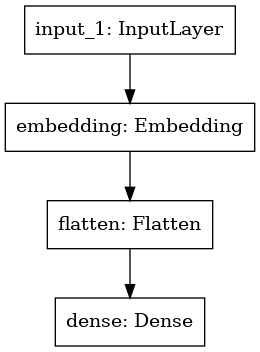

In [7]:
## Training

inputs = tf.keras.Input(shape = (14804, ))

embedding = tf.keras.layers.Embedding(
    input_dim = 30000,
    output_dim = 64
)(inputs)

flatten = tf.keras.layers.Flatten()(embedding)

outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(flatten)

model = tf.keras.Model(inputs = inputs, outputs = outputs)

model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = [
        'accuracy',
        tf.keras.metrics.AUC(name = 'auc')
    ]
)

print(model.summary())
tf.keras.utils.plot_model(model)


In [8]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

2022-12-16 04:47:10.963992: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
102/102 [==============================] - 5s 33ms/step - loss: 0.5417 - accuracy: 0.8354 - auc: 0.8538 - val_loss: 0.0929 - val_accuracy: 0.9766 - val_auc: 0.9967
Epoch 2/100
102/102 [==============================] - 3s 29ms/step - loss: 0.0459 - accuracy: 0.9874 - auc: 0.9994 - val_loss: 0.0414 - val_accuracy: 0.9865 - val_auc: 0.9988
Epoch 3/100
102/102 [==============================] - 3s 30ms/step - loss: 0.0139 - accuracy: 0.9978 - auc: 1.0000 - val_loss: 0.0344 - val_accuracy: 0.9877 - val_auc: 0.9989
Epoch 4/100
102/102 [==============================] - 3s 32ms/step - loss: 0.0069 - accuracy: 0.9994 - auc: 1.0000 - val_loss: 0.0326 - val_accuracy: 0.9901 - val_auc: 0.9991
Epoch 5/100
102/102 [==============================] - 3s 30ms/step - loss: 0.0044 - accuracy: 0.9994 - auc: 1.0000 - val_loss: 0.0341 - val_accuracy: 0.9914 - val_auc: 0.9991
Epoch 6/100
102/102 [==============================] - 3s 29ms/step - loss: 0.0031 - accuracy: 0.9994 - auc: 1.0000 - va

Test Loss: 0.02431
 Accuracy: 99.14%
      AUC: 0.99884


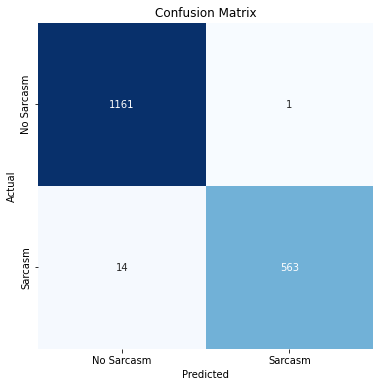

Classification Report:
----------------------
               precision    recall  f1-score   support

  No Sarcasm       0.99      1.00      0.99      1162
     Sarcasm       1.00      0.98      0.99       577

    accuracy                           0.99      1739
   macro avg       0.99      0.99      0.99      1739
weighted avg       0.99      0.99      0.99      1739



In [15]:
results = model.evaluate(X_test, y_test, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print(" Accuracy: {:.2f}%".format(results[1] * 100))
print("      AUC: {:.5f}".format(results[2]))

y_pred = np.squeeze(model.predict(X_test) >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
clr = classification_report(y_test, y_pred, labels=[0, 1], target_names=["No Sarcasm", "Sarcasm"])

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["No Sarcasm", "Sarcasm"])
plt.yticks(ticks=[0.5, 1.5], labels=["No Sarcasm", "Sarcasm"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

In [9]:
add_docstring

NameError: name 'add_docstring' is not defined